In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from sklearn.neighbors import KernelDensity # GridSearchCV 용
from scipy.stats import gaussian_kde # cdf 산출이 가능한 library 이용 >> 같은 bandwidth를 적용하면 같은 결과가 나옴 (https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)
import numpy as np
import pandas as pd

# https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python : GridSearchCV가 어떻게 작용되는지 보러면 이거 참고하면 될 듯
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from scipy.stats import norm, ks_2samp
import matplotlib.pyplot as plt

def bw_selection(data):
  PCnum = data.shape[1]
  bandwidths = 10**np.linspace(-1, 1, 100)

  for i in range(PCnum):
    grid = GridSearchCV(KernelDensity(kernel = "gaussian"),
                        {"bandwidth" : bandwidths},
                        cv = LeaveOneOut())
    X = data.iloc[:, i][:, None]
    grid.fit(X)
    kde = grid.best_estimator_
    print("optimal bandwidth of {0}th PC : {1:.2f}".format(i+1, kde.bandwidth))

def kde_to_normal(data, bandwidths):
  PCnum = data.shape[1]
  temp = []
  fig, axe = plt.subplots(1, PCnum, figsize=(PCnum*4, 4))

  for i in range(PCnum):
    X = data.iloc[:, i]

    # Note that scipy weights its bandwidth by the covariance of the input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(X, bw_method=bandwidths[i] / X.std(ddof=1))
    print(ks_2samp(X, kde.resample(100).squeeze())) # Checking samples with Kolmogorov-Smirnov Test. null hypothesis : two distributions are identical

    # to calculate cdf
    xx = np.arange(np.min(X)-1, np.max(X), 0.1)
    K = kde(xx)
    cdf_probs = [kde.integrate_box_1d(-np.Inf, x) for x in X]
    C = [kde.integrate_box_1d(-np.Inf,x) for x in xx]
    temp.append(norm.ppf(cdf_probs))
    
    axe[i].hist(X, density=1)
    axe[i].plot(xx, K, label="PDF")
    axe[i].plot(xx, C, label="CDF")
    axe[i].set_title('Kernel Density Estimation of {0}th PC'.format(i+1))
    axe[i].legend(loc='best')
  
  result = pd.DataFrame(temp).transpose()
  plt.show()
  return(result)

# 고객요인

Comp 1이 설명하는 분산 비율이 78.03819%이므로 별도의 가중치 없이 kde를 이용해 standardize만 적용 

In [6]:
path = '/content/drive/Shareddrives/통분방+공모전/데이터/데이터정리 최종/'
customer_trans = pd.read_csv(path+"고객요인_변환.csv", encoding="euc-kr")
customer_trans.head() # Comp.1만 사용

,Comp.1,Comp.2
0,3.633189,-2.832368
1,3.633189,-2.832368
2,3.633189,-2.832368
3,3.633189,-2.832368
4,1.637285,-0.615100


In [ ]:
customer_data = pd.read_csv(path+"고객요인.csv", encoding = "euc-kr")
customer_data.head()

,시장.상점가명.,시군구,평균소득월액,인구수,X0.29세,X30.59세,X60세.이상
0,강남시장,서울특별시강남구,1670051,529946,0.304837,0.481662,0.213502
1,신사상가,서울특별시강남구,1670051,529946,0.304837,0.481662,0.213502
2,영동전통시장,서울특별시강남구,1670051,529946,0.304837,0.481662,0.213502
3,청담삼익시장,서울특별시강남구,1670051,529946,0.304837,0.481662,0.213502
4,고분다리전통시장,서울특별시강동구,1406722,460413,0.282911,0.467585,0.249506


In [ ]:
customer_data.columns

Index(['시장.상점가명.', '시군구', '평균소득월액', '인구수', 'X0.29세', 'X30.59세', 'X60세.이상'], dtype='object')

In [ ]:
customer_temp = pd.concat([customer_data, customer_trans], axis=1)
customer_temp.sort_values("시장.상점가명.", inplace=True)
customer_temp.head()

,시장.상점가명.,시군구,평균소득월액,인구수,X0.29세,X30.59세,X60세.이상,Comp.1,Comp.2
1060,(유)문경시중앙시장,경상북도문경시,1225542,70847,0.212232,0.358703,0.429074,-2.660901,0.107726
976,(주)서시장,전라남도여수시,1292967,275011,0.274400,0.424961,0.300641,0.000975,-0.009159
545,(주)신정시장,울산광역시남구,1356088,310784,0.293641,0.479307,0.227054,1.542027,-0.543312
546,(주)야음시장,울산광역시남구,1356088,310784,0.293641,0.479307,0.227054,1.542027,-0.543312
989,(주)여수수산시장,전라남도여수시,1292967,275011,0.274400,0.424961,0.300641,0.000975,-0.009159


In [ ]:
customer_trans = customer_temp.iloc[:, -2:].reset_index(drop=True)
customer_trans.head()

,Comp.1,Comp.2
0,-2.660901,0.107726
1,0.000975,-0.009159
2,1.542027,-0.543312
3,1.542027,-0.543312
4,0.000975,-0.009159


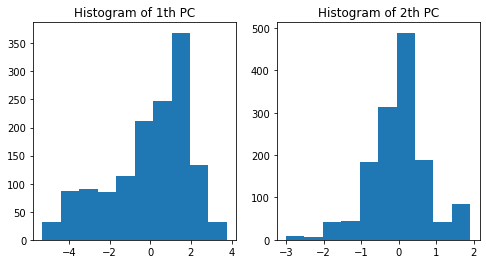

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.hist(customer_trans.iloc[:, i])
  plt.title("Histogram of {0}th PC".format(i+1))
plt.show()

In [ ]:
bw_selection(customer_trans)

optimal bandwidth of 1th PC : 0.10
optimal bandwidth of 2th PC : 0.10


KstestResult(statistic=0.08510349750178443, pvalue=0.48181903497677825)
KstestResult(statistic=0.06907209136331192, pvalue=0.7358782864356035)


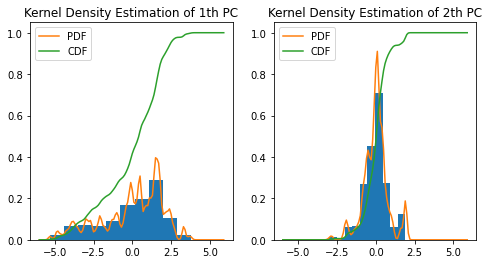

In [ ]:
customer_result = kde_to_normal(customer_trans, [0.1, 0.1])

In [ ]:
customer_result.head()

,0,1
0,-1.076366,0.176048
1,-0.210414,-0.084350
2,0.686679,-0.839135
3,0.686679,-0.839135
4,-0.210414,-0.084350


In [ ]:
customer_result.describe()

,0,1
count,1401.000000,1401.000000
mean,-0.000933,-0.004297
std,0.993648,0.975936
min,-2.856528,-3.090135
25%,-0.655157,-0.679829
50%,0.008762,0.086774
75%,0.642436,0.647143
max,2.935829,1.984947


In [ ]:
customer = customer_result.iloc[:, 0]

In [ ]:
customer.describe()

count    1401.000000
mean       -0.000933
std         0.993648
min        -2.856528
25%        -0.655157
50%         0.008762
75%         0.642436
max         2.935829
Name: 0, dtype: float64

# 시장요인

3개의 다양성 인덱스를 하나의 지수로 계산하는 방법

: 각 요소 가중치 값에 해당 지수의 설명력을 곱하여 weighted된 가중치 값을 계산

→ weighted된 가중치 값을 normalized된 해당 변수 값에 곱한 합을 계산하여 하나의 지수 값을 도출

In [ ]:
# Comp 1 ~ 3이 설명하는 분산 비율이 22.56743 15.89962 13.59015 이므로 이를 가중치로 두어 시장요인 최종 
weights = [22.56743, 15.89962, 13.59015]

In [ ]:
market_trans = pd.read_csv(path+"시장요인_변환최종.csv", encoding="euc-kr")
market_trans.head()

,coord.Dim.1,coord.Dim.2,coord.Dim.3
0,-0.851100,0.115219,-0.136433
1,-1.285720,0.589600,-0.455253
2,-1.041685,-0.962739,0.563798
3,-0.218891,0.252475,-0.722153
4,-1.238056,-0.734730,-0.091955


In [ ]:
market_data = pd.read_csv(path+"시장요인.csv", encoding = "euc-kr")
market_data.head() # sort_values가 완료된 형태 >> 그대로 진행

,시장명,화장실,주차장,농산물,축산물,수산물,점포수,개설연도,배송서비스,장보기서비스
0,(유)문경시중앙시장,Y,Y,Y,N,N,38,2005,N,N
1,(주)서시장,Y,Y,N,N,Y,209,1982,N,N
2,(주)신정시장,Y,N,N,N,Y,87,1998,N,N
3,(주)야음시장,Y,Y,N,Y,Y,90,1976,N,N
4,(주)여수수산시장,Y,N,N,N,Y,115,1969,N,N


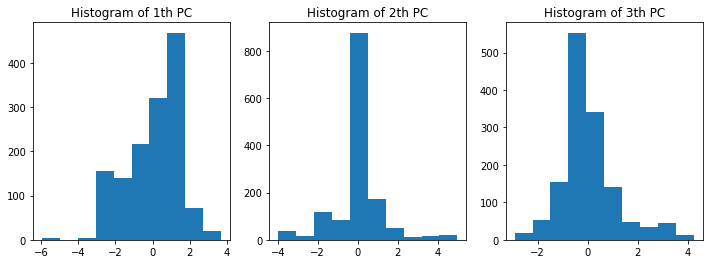

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.hist(market_trans.iloc[:, i])
  plt.title("Histogram of {0}th PC".format(i+1))
plt.show()

PC마다 scale이 다 다르기 때문에 standardize 필요 >> KDE 이용

kde에서는 bandwidth selection이 매우 중요 (매우 작으면 overfitting, 매우 크면 underfitting 가능성)

데이터 수가 많지 않으므로 LOOCV를 통해 best estimator select

In [ ]:
bw_selection(market_trans)

optimal bandwidth of 1th PC : 0.10
optimal bandwidth of 2th PC : 0.10
optimal bandwidth of 3th PC : 0.10


KstestResult(statistic=0.11294075660242683, pvalue=0.1710928375840659)
KstestResult(statistic=0.0523982869379015, pvalue=0.9471467372791438)
KstestResult(statistic=0.09397573162027123, pvalue=0.3576925309013923)


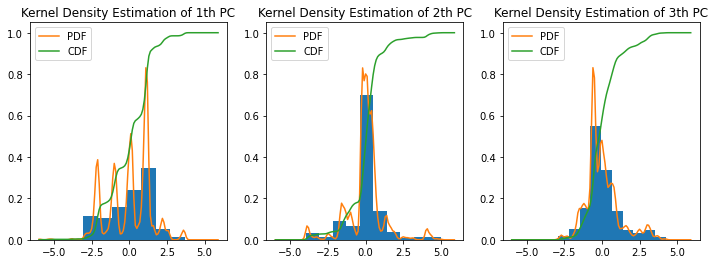

In [ ]:
market_result = kde_to_normal(market_trans, [0.1, 0.1, 0.1])

In [ ]:
market_result.head()

,0,1,2
0,-0.481499,0.146603,0.048061
1,-0.862206,0.980436,-0.282290
2,-0.677096,-1.016283,0.747295
3,-0.338886,0.382485,-0.873850
4,-0.841371,-0.937217,0.098702


In [ ]:
market_result.describe()

,0,1,2
count,1401.000000,1401.000000,1401.000000
mean,-0.002672,0.001608,0.002153
std,0.981289,0.984873,0.990200
min,-3.384232,-2.662184,-3.285937
25%,-0.665361,-0.612570,-0.631908
50%,0.008915,0.010744,0.025241
75%,0.717476,0.635952,0.678205
max,2.691461,3.379191,3.327558


In [ ]:
weights = weights/np.sum(weights)
weights

array([0.43351218, 0.30542595, 0.26106187])

In [ ]:
market = market_result.iloc[:, 0]*weights[0]+market_result.iloc[:, 1]*weights[1]+market_result.iloc[:, 2]*weights[2]

In [ ]:
market.describe()

count    1401.000000
mean       -0.000105
std         0.539260
min        -0.912447
25%        -0.266214
50%        -0.111429
75%         0.018306
max         2.368296
dtype: float64

# 외부요인

In [ ]:
# Comp 1 ~ 2가 설명하는 분산 비율이 58.29146 12.63792이므로 이를 가중치로 두어 시장요인 최종 
weights = [58.29146, 12.63792]

In [11]:
out_trans = pd.read_csv(path+"외부요인_변환.csv", encoding="euc-kr")
out_trans.head()

,Comp.1,Comp.2
0,-1.095615,-1.227276
1,-0.575845,-1.315928
2,0.286512,0.126396
3,-0.312946,0.004353
4,-0.151584,-0.678504


In [18]:
out_trans.describe()

,Comp.1,Comp.2
count,1.401000e+03,1.401000e+03
mean,-7.137886e-13,4.282656e-12
std,2.020722e+00,9.408967e-01
min,-2.821549e+00,-1.812959e+00
25%,-1.701128e+00,-5.683770e-01
50%,-2.359402e-01,-9.690807e-02
75%,1.251075e+00,4.275695e-01
max,1.051697e+01,8.348463e+00


In [ ]:
out_data = pd.read_csv(path+"외부요인.csv", encoding = "euc-kr")
out_data.head() # sort_values 완료된 형태 >> 별도의 전처리 없이 진행

,시장명,편의점 수,대형마트 여부,지하철역 여부,카페 수,음식점 수,학교 수,유동인구
0,(유)문경시중앙시장,17,0,0,75,489,6,949
1,(주)서시장,20,0,0,121,730,8,964
2,(주)신정시장,75,1,0,171,1112,8,3031
3,(주)야음시장,30,0,0,94,458,9,5566
4,(주)여수수산시장,29,0,0,162,913,7,3080


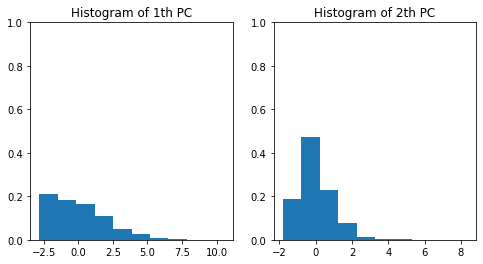

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.hist(out_trans.iloc[:, i], density=1)
  plt.title("Histogram of {0}th PC".format(i+1))
  plt.ylim([0, 1]) 
plt.show()

In [ ]:
bw_selection(out_trans)

optimal bandwidth of 1th PC : 0.31
optimal bandwidth of 2th PC : 0.40


KstestResult(statistic=0.0736830835117773, pvalue=0.6628419617226864)
KstestResult(statistic=0.1087937187723055, pvalue=0.20357708376686035)


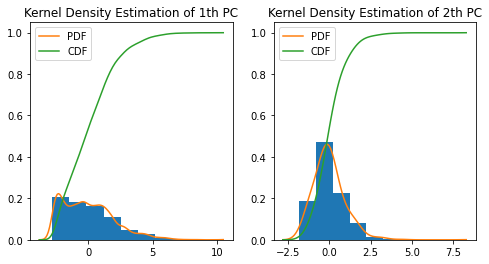

In [17]:
out_result = kde_to_normal(out_trans, [0.31, 0.4])

In [ ]:
out_result.describe()

,0,1
count,1401.000000,1401.000000
mean,0.015542,0.015024
std,0.954511,0.901713
min,-1.892944,-2.114352
25%,-0.686626,-0.555526
50%,-0.002055,-0.011380
75%,0.669941,0.562043
max,3.384232,3.384232


In [ ]:
weights = weights/np.sum(weights)
weights

array([0.8218239, 0.1781761])

In [ ]:
out = out_result.iloc[:, 0]*weights[0]+out_result.iloc[:, 1]*weights[1]

In [ ]:
out.describe()

count    1401.000000
mean        0.015449
std         0.794741
min        -1.614533
25%        -0.546013
50%        -0.020788
75%         0.531615
max         2.914950
dtype: float64

In [ ]:
final = pd.concat([out_data.시장명, customer, market, out], axis=1)
final.columns = ["시장명", "customer", "market", "out"]
final.head()

,시장명,customer,market,out
0,(유)문경시중앙시장,-1.076366,-0.151412,-0.559493
1,(주)서시장,-0.210414,-0.148021,-0.383694
2,(주)신정시장,0.686679,-0.408838,0.228109
3,(주)야음시장,0.686679,-0.258219,-0.011811
4,(주)여수수산시장,-0.210414,-0.625228,-0.091687


In [ ]:
final.to_csv(path+"cus_mar_out.csv", index=False)